# 1.Import Libraries

In [1]:
# data analysis libraries:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype 

# data visualization libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# to ignore warnings:
import warnings
warnings.filterwarnings('ignore')

#timer library
from contextlib import contextmanager
import time

#ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

# 2. Timer Function

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# 3. Data Preprocessing

In [3]:
def spilit_and_preprocessing():
    
    print("Data Preprocessing Has Been Started" "\n")

    data= pd.read_csv('Churn_Modelling.csv')
    df= data.copy()

    df= df.drop(['RowNumber','Surname'], axis=1)
    
    return df

# 4. Feature Engineering

As a result of data examinations; it was observed that there were no outlier values or missing values in the data. After that, feature engineering operations were started directly.

Some addition operations related to numerical variables were made on the basis of categorical variables.

Some crossing and ratio operations are done on numerical variables.

Finally, encoding was performed in categorical variables.

In [4]:
def feature_engineering(df):
    
    print("Feature Engineering Process Has Been Started" "\n")
    
    agg_list = {"CreditScore":["mean",'std','min','max'],
                "Tenure":["mean",'min', 'max'],
                "Balance":["median",'std','min','max'],
                "NumOfProducts":["mean",'min', 'max'],
                "EstimatedSalary":["median",'std','min','max'],
                "Age":["mean",'min','max'] }
    
    
    df_gender = df.groupby("Gender").agg(agg_list)
    df_gender.columns = pd.Index([col[0] + "_" + col[1].upper() + '_Gender' for col in df_gender.columns.tolist()])
    df_gender=df_gender.reset_index()

    df_geography = df.groupby("Geography").agg(agg_list)
    df_geography.columns = pd.Index([col[0] + "_" + col[1].upper() + '_Geography' for col in df_geography.columns.tolist()])
    df_geography=df_geography.reset_index()
 
    df_HasCrCard = df.groupby("HasCrCard").agg(agg_list)
    df_HasCrCard.columns = pd.Index([col[0] + "_" + col[1].upper() + '_HasCrCard' for col in df_HasCrCard.columns.tolist()])
    df_HasCrCard=df_HasCrCard.reset_index()

    df_IsActiveMember = df.groupby("IsActiveMember").agg(agg_list)
    df_IsActiveMember.columns = pd.Index([col[0] + "_" + col[1].upper() + '_IsActiveMember' for col in df_IsActiveMember.columns.tolist()])
    df_IsActiveMember=df_IsActiveMember.reset_index()

    df = df.merge(df_gender, how='left', on= 'Gender')

    df = df.merge(df_geography, how='left', on= 'Geography')

    df = df.merge(df_HasCrCard, how='left', on= 'HasCrCard')

    df = df.merge(df_IsActiveMember, how='left', on= 'IsActiveMember')
    
    print("Categorical Features Aggregations Process has been finished" "\n")
    
    
    df['HasCrCard_2'] = df['HasCrCard'].replace(to_replace = 0, value = -1)
    df['IsActiveMember_2'] = df['IsActiveMember'].replace(to_replace = 0, value = -1)
    
    
    df['Age_Balance_Ratio'] = df.Balance / df.Age

    df['Age_Cross_NumOfProducts'] = df.Age * df.NumOfProducts

    df['Score_Age_Ratio'] = df.CreditScore / df.Age

    df['Age_Salary_Ratio'] = df.EstimatedSalary / df.Age

    df['Balance_Salary_Ratio'] = df.Balance / df.EstimatedSalary

    df['Score_Balance_Ratio'] = df.Balance / df.CreditScore

    df['Score_Salary_Ratio'] = df.CreditScore / df.EstimatedSalary

    df['Score_HasCrCard_2'] = df.CreditScore * df.HasCrCard_2

    df['Score_Cross_NumOfProducts'] = df.CreditScore * df.NumOfProducts

    df['Balance_NumOfProducts_Ratio'] = df.CreditScore / df.NumOfProducts

    df['Age_Cross_HasCrCard_2'] = df.Age * df.HasCrCard_2

    df['Balance_Cross_HasCrCard_2'] = df.Balance * df.HasCrCard_2

    df['Age_Cross_IsActiveMember_2'] = df.Age * df.IsActiveMember_2

    df['Score_Cross_IsActiveMember_2'] = df.CreditScore * df.IsActiveMember_2

    df['Balance_Cross_IsActiveMember_2'] = df.Balance * df.IsActiveMember_2

    df['Tenure_Cross_Balance'] = df.Balance * df.Tenure

    df['Tenure_Cross_NumOfProducts'] = df.Tenure * df.NumOfProducts

    df['Score_Cross_Tenure'] = df.Tenure * df.CreditScore

    df['Tenure_Salary_Ratio'] = df.Tenure / df.EstimatedSalary

    df= df.drop(['IsActiveMember_2', 'HasCrCard_2'], axis=1)
    
    print("Cross Accounts Features Process has been finished" "\n")
    
    
    df = pd.get_dummies(df, columns = ["Gender"], prefix = ["Gender"], drop_first= True)

    df = pd.get_dummies(df, columns = ["Geography"], prefix = ["Geography"], drop_first= True)

    df = pd.get_dummies(df, columns = ["HasCrCard"], prefix = ["HasCrCard"], drop_first= True)

    df = pd.get_dummies(df, columns = ["IsActiveMember"], prefix = ["IsActiveMember"], drop_first= True)
    
    print("Label Encoding Process has been finished" "\n")
    
    return df

# 5. Machine Learning And Predictions

The competition data are not divided into test and train. To test the success of the model, the test data must first be separated from the main data.

I determined the ratio of the number of observations of the test data to the number of observations of the main table as 1/5.

Created the test data taking into account the proportions of the classes of the target variable in the main table.

Chose Catboost, one of the algorithms that gives the best results on this data.

Also tried to achieve the best result by doing hyperparameter optimization on the catboost algorithm for this job.

I specified the prediction success of the algorithm on the train set as "Train Data Success Score".

Finally, I used 400 samples randomly selected from test data to measure the success of the algorithm's estimation on test data. I mentioned this as "Random Sample Success Score".


In [5]:
def training_model_and_predicting(df):

    print("Model fitting process has been started" "\n")
    
    # Main test - train data splitting
    target_1=  df[df['Exited']==1]
    test_1= target_1.sample(400)

    target_0=  df[df['Exited']==0]
    test_0= target_0.sample(1600)

    test = pd.concat([test_1, test_0], axis=0)
    df = df.drop(test.index)

    test_data_for_final=test[['CustomerId', 'Exited']]# this is for random sample success score

    test= test.drop('Exited', axis=1)
    
    # train test spilit on train data 
    predictors = df.drop(['Exited', 'CustomerId'], axis=1)
    target = df["Exited"]
    x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.20, random_state = 0)
        
    
    # Tuned model fitting with optimum parameters
    catb = CatBoostClassifier(iterations = 300, learning_rate = 0.04, depth = 5)

    catb_tuned = catb.fit(x_train, y_train)
    y_pred = catb_tuned.predict(x_val)
    acc_catb = round(accuracy_score(y_pred, y_val) * 100, 2)
    print('Train Data Success Score: %' + str(acc_catb))
    
    
    #set ids as CustomerId and predict Exited# fitting final model with the best model 
    ids = test['CustomerId']
    predictions = catb_tuned.predict(test.drop('CustomerId', axis=1))

    #set the output as a dataframe and convert to csv file named submission.csv
    output = pd.DataFrame({ 'CustomerId' : ids, 'Exited': predictions })
    output.to_csv('submission.csv', index=False)
    
    
    #Finally, I test the success of the model with 400 samples randomly selected from the test data.
    test_data_last = test_data_for_final.sample(400)
    testing = test_data_last.merge(output, how= 'left', on = 'CustomerId')
    testing.columns= ['CustomerId','Exited_test','Exited_output']
    testing['toplam'] = testing.Exited_test + testing.Exited_output
    a = testing[testing.toplam!=1].count().iloc[0]
    b= testing.count().iloc[0]
    
    print('Random Sample Success Score: %' + str(a/b*100))
    
    print("Submission file has been created")
    
    
    #feature importances table
    feature_imp = pd.Series(catb_tuned.feature_importances_,
                        index=x_train.columns).sort_values(ascending=False).iloc[:20]

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature importances scores')
    plt.ylabel('Features')
    plt.title("Feature importances")
    plt.figure(figsize=(15,20))
    plt.tight_layout()
    plt.savefig('Catboost_importances01.png')

In [6]:
def main():
    
    with timer("Preprocessing Time"):
        df = spilit_and_preprocessing()
        
    with timer("Feature Engineering Time"):
        df = feature_engineering(df)        
        
    with timer("Modelling Time"):
        training_model_and_predicting(df)
    

Data Preprocessing Has Been Started

Preprocessing Time - done in 0s
Feature Engineering Process Has Been Started

Categorical Features Aggregations Process has been finished

Cross Accounts Features Process has been finished

Label Encoding Process has been finished

Feature Engineering Time - done in 1s
Model fitting process has been started

0:	learn: 0.6696986	total: 167ms	remaining: 50s
1:	learn: 0.6395803	total: 194ms	remaining: 28.9s
2:	learn: 0.6158916	total: 217ms	remaining: 21.5s
3:	learn: 0.5949404	total: 245ms	remaining: 18.1s
4:	learn: 0.5739582	total: 270ms	remaining: 15.9s
5:	learn: 0.5567890	total: 295ms	remaining: 14.5s
6:	learn: 0.5382856	total: 325ms	remaining: 13.6s
7:	learn: 0.5203051	total: 348ms	remaining: 12.7s
8:	learn: 0.5083873	total: 379ms	remaining: 12.3s
9:	learn: 0.4962357	total: 418ms	remaining: 12.1s
10:	learn: 0.4836807	total: 446ms	remaining: 11.7s
11:	learn: 0.4735051	total: 470ms	remaining: 11.3s
12:	learn: 0.4647019	total: 496ms	remaining: 11s
13:	

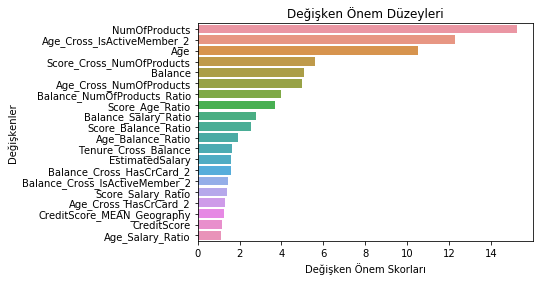

<Figure size 1080x1440 with 0 Axes>

In [7]:
if __name__ == "__main__":
    with timer("Full model run"):
        main()